In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T
import torch.nn.functional as F
torch.manual_seed(3407)

In [2]:
class PatchEmbedding(nn.Module):
    def __init__(self,
                 in_channels = 3,
                 patch_size = 16,
                 embedding_dim = 768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels = in_channels,
                                out_channels = embedding_dim,
                                kernel_size = patch_size,
                                stride = patch_size,
                                padding = 0)# 3x224x224 => 768x14x14
        
        self.flat = nn.Flatten(start_dim=2,end_dim=3)#768x14x14 =>768x192
        
    def forward(self,x):
        return self.flat(self.patcher(x)).permute(0,2,1)#192x768
    
    
    
class PositionwiseFeedForward(nn.Module):
    def __init__(self,d_model, ffn_hidden , drop_prob):
        super().__init__()
        self.linear1 = nn.Linear(d_model,ffn_hidden)
        self.dropout1 = nn.Dropout(drop_prob)
        self.GELU = nn.GELU()
        self.linear2 = nn.Linear(ffn_hidden, d_model)
        
    def forward(self,x):
        x = self.dropout1(self.GELU(self.linear1(x)))
        return self.linear2(x)
    
def scaled_dot_product(q,k,v):
    d_k = q.size()[-1]#200x12x192x64 X 200x12x
    scaled = q@k.transpose(-1,-2)*d_k**(-0.5)#200x12x192x64 X 200x12x64x192 => 200x12x192x192
    attention = F.softmax(scaled, dim=-1)
    values = attention@v#200x12x192x64 
    return values, attention
    
class MultiHeadAttention(nn.Module):
    def __init__(self,
                 d_model = 768,
                 n_heads = 12):
        super().__init__()
        self.d_model = d_model
        self.n_heads = n_heads
        self.head_dim = d_model//n_heads
        self.qkv_layer = nn.Linear(d_model,d_model*3)
        self.linear = nn.Linear(d_model,d_model)
        
    def forward(self,x):
        batch_size, sequence_length, d_model = x.size()
        qkv = self.qkv_layer(x)#200x192x768*3
        qkv = qkv.reshape(batch_size,sequence_length,self.n_heads,self.head_dim*3).permute(0,2,1,3)#200x12x192x192
        q,k,v = qkv.chunk(3,dim=-1)# 200x12x192x64
        values, attention = scaled_dot_product(q,k,v)
        values = values.permute(0,2,1,3).reshape(batch_size,sequence_length,d_model)
        
        return self.linear(values)
        
class Block(nn.Module):
    def __init__(self,
                 d_model = 768,
                 n_heads = 12,
                 drop_prob = 0.2):
        super().__init__()
        self.attention = MultiHeadAttention(d_model,n_heads)
        self.norm1 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(drop_prob)
        self.ffn = PositionwiseFeedForward(d_model=d_model, ffn_hidden=d_model*3, drop_prob=drop_prob)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout2 = nn.Dropout(p=drop_prob)
    def forward(self, x):
        x = x + self.dropout(self.attention(self.norm1(x)))
        x = x + self.dropout2(self.ffn(self.norm2(x)))
        return x 
                 

In [3]:
class Vit(nn.Module):

    def __init__(self,in_channels = 3, img_size = 224, patch_size = 16,
               num_transformer_layers = 6, emb_dim = 768,#3x16x16
                 mlp_size = 768*4, num_heads = 12,
               attn_dropout = 0, mlp_dropout = 0.2,
                 emd_dropout = 0.1, num_classes = 37
               ):
        
        super().__init__()
        self.num_patches = (img_size * img_size)//(patch_size*patch_size)#=196 количество кубиков на которые делим картинку
        self.class_embd = nn.Parameter(data = torch.randn(1, 1, emb_dim),requires_grad = True)
        self.pos_embd = nn.Parameter(data = torch.randn(1, self.num_patches+1, emb_dim),requires_grad = True)
        self.patch_emb = PatchEmbedding(in_channels, patch_size, emb_dim )
        #self.emb_dropout = nn.Dropout(emd_dropout)
        self.TransformerEncoders = nn.Sequential(*[Block(emb_dim,num_heads,mlp_dropout) for i in range(num_transformer_layers)])
        self.classifier = nn.Sequential(*[
            nn.LayerNorm(normalized_shape = emb_dim),
            nn.Linear(emb_dim,num_classes)
        ])
    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embd.expand(batch_size,-1,-1)
        x = self.patch_emb(x)
        x = torch.cat((class_token,x),dim = 1)
        x = self.pos_embd + x
        #x = self.emb_dropout(x)
        x = self.TransformerEncoders(x)
        x = self.classifier(x[:,0])
        return x

In [4]:
Vit()(torch.randn(74,3,224,224)).shape

torch.Size([74, 37])

# Обучение

In [5]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as T


batch_size = 64

#transform = transforms.Compose([transforms.Resize((224,224)),transforms.ToTensor()])
#data = torchvision.datasets.OxfordIIITPet(root='./data',
                                        #download=True, transform=transform)

transform = T.Compose(
    [
        T.Resize((224, 224)),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ]
)

In [7]:
train_dataset =torchvision.datasets.OxfordIIITPet(root='./data',
                                        download=True, transform=transform)
valid_dataset =torchvision.datasets.OxfordIIITPet(root='./data',split='test',
                                        download=True, transform=transform)


In [8]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size = 64*2, shuffle=True, num_workers = 12,persistent_workers=True,
                          pin_memory = True)
valid_loader = DataLoader(valid_dataset, batch_size = 64*2, shuffle=False,num_workers = 4,persistent_workers=True,
                          pin_memory = True)

In [9]:
sum([p.numel() for p in Vit(num_transformer_layers=10).parameters()])

59847205

In [10]:
from IPython.display import clear_output

from tqdm import tqdm
import matplotlib.pyplot as plt

def train(model) -> float:
    model.train()

    train_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(train_loader, desc='Train'):
        x, y = x.to(device), y.to(device)

        optimizer.zero_grad()

        output = model(x)

        loss = loss_fn(output, y)

        train_loss += loss.item()

        loss.backward()

        optimizer.step()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    train_loss /= len(train_loader)
    accuracy = correct / total

    return train_loss, accuracy



@torch.inference_mode()
def evaluate(model, loader) -> tuple[float, float]:
    model.eval()

    total_loss = 0
    total = 0
    correct = 0

    for x, y in tqdm(loader, desc='Evaluation'):
        x, y = x.to(device), y.to(device)

        output = model(x)

        loss = loss_fn(output, y)

        total_loss += loss.item()

        _, y_pred = torch.max(output, 1)
        total += y.size(0)
        correct += (y_pred == y).sum().item()

    total_loss /= len(loader)
    accuracy = correct / total

    return total_loss, accuracy



def plot_stats(
    train_loss: list[float],
    valid_loss: list[float],
    train_accuracy: list[float],
    valid_accuracy: list[float],
    title: str
):
    plt.figure(figsize=(16, 8))

    plt.title(title + ' loss')

    plt.plot(train_loss, label='Train loss')
    plt.plot(valid_loss, label='Valid loss')
    plt.legend()
    plt.grid()

    plt.show()

    plt.figure(figsize=(16, 8))

    plt.title(title + ' accuracy')

    plt.plot(train_accuracy, label='Train accuracy')
    plt.plot(valid_accuracy, label='Valid accuracy')
    plt.legend()
    plt.grid()

    plt.show()



def whole_train_valid_cycle_with_scheduler(model, num_epochs, title):
    train_loss_history, valid_loss_history = [], []
    train_accuracy_history, valid_accuracy_history = [], []

    for epoch in range(num_epochs):
        train_loss, train_accuracy = train(model)
        valid_loss, valid_accuracy = evaluate(model, valid_loader)

        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)

        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(valid_accuracy)

        clear_output()

        plot_stats(
            train_loss_history, valid_loss_history,
            train_accuracy_history, valid_accuracy_history,
            title
        )

       #scheduler.step()
#Torch.manual_seed(3407)

In [11]:


device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

model = Vit(in_channels = 3, img_size = 224, patch_size = 16,
            num_transformer_layers = 4, emb_dim = 768,#3x16x16
            mlp_size = 768*4, num_heads = 12,
            attn_dropout = 0, mlp_dropout = 0.2,
            emd_dropout = 0.1, num_classes = 37
               ).to(device)

# model = Vit(in_channels = 3, img_size = 32,
#     patch_size = 4, num_transformer_layers = 2,
#     emb_dim = 4*4*3 ,mlp_size = 4*4*3*4,
#     num_classes = 10).to(device)

optimizer = torch.optim.RAdam(model.parameters(),lr = 3e-4,weight_decay = 2e-4)
loss_fn = nn.CrossEntropyLoss()

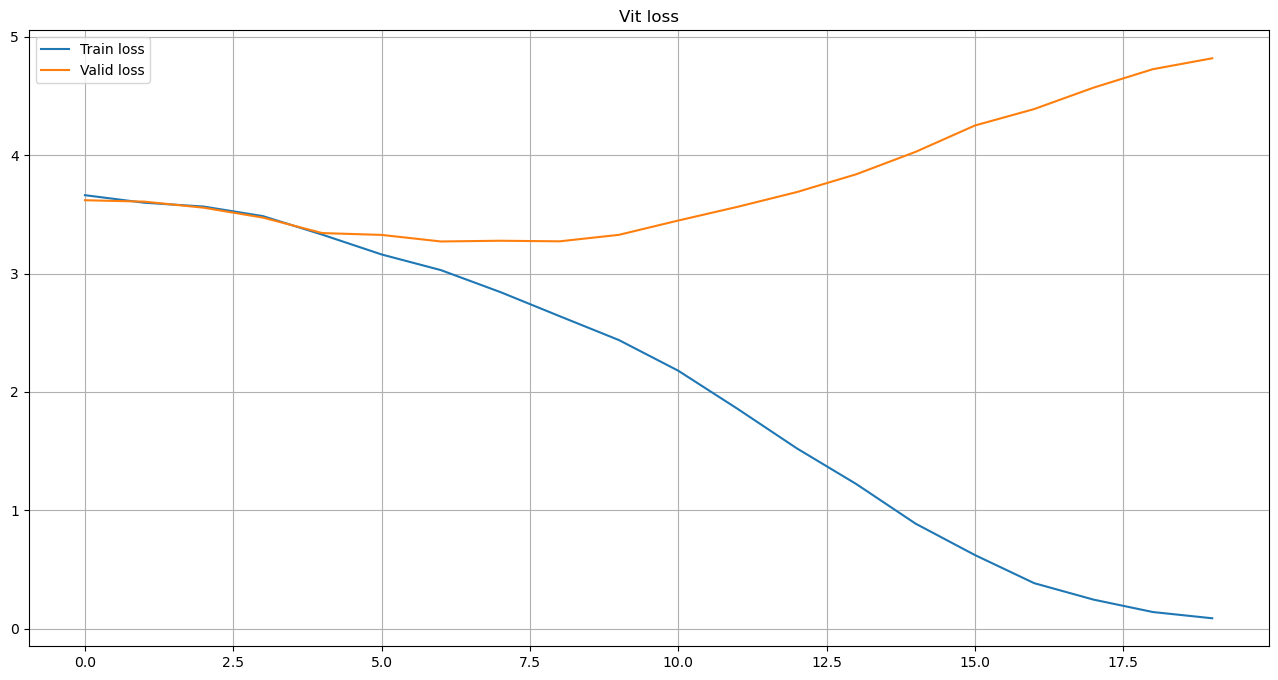

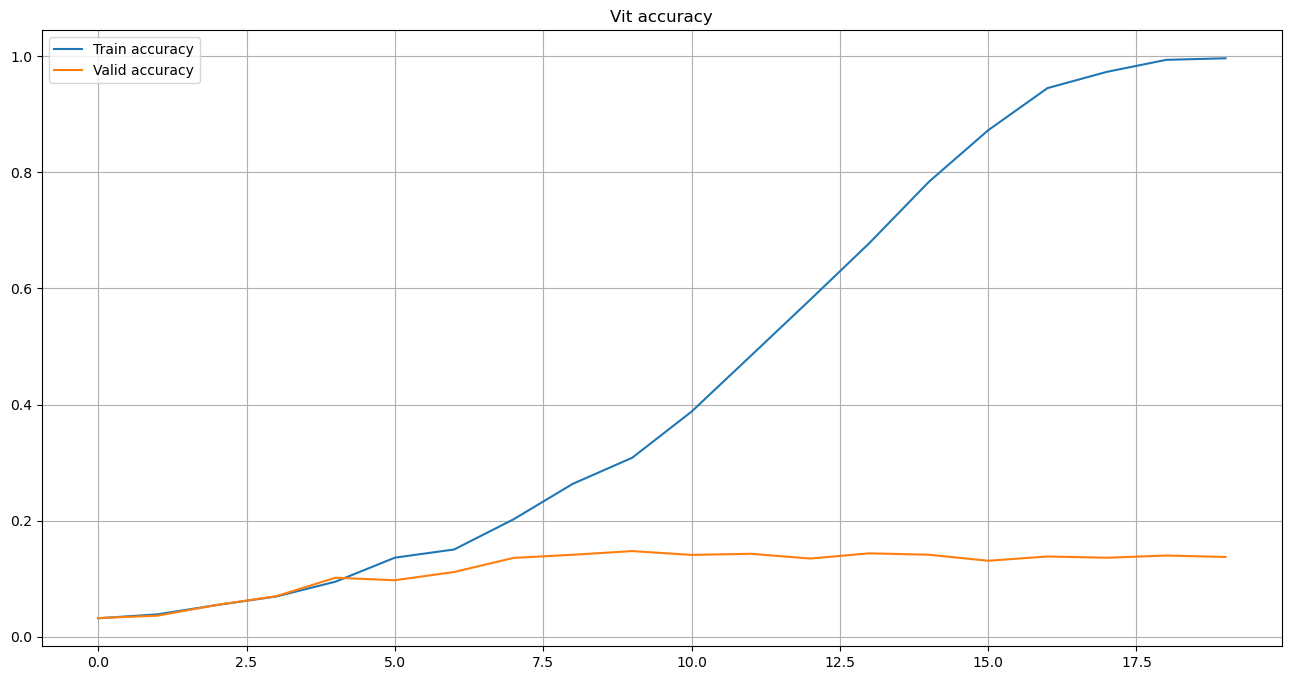

Train:  69%|███████████████████████████████████████████████████▋                       | 20/29 [00:06<00:02,  3.00it/s]


KeyboardInterrupt: 

In [12]:
whole_train_valid_cycle_with_scheduler(model,40,"Vit")